#  Raw To Image Project

Author: xueqin.chen


## Implement a basic image processing pipeline

Requirements:

Input: It is a RAW image that was captured with a Canon EOS T3 Rebel camera. Input data located in ./data/banana slug.tiff

Output: A traditional image which can be normally display in PC.

### Initials

Load the image into Matlab. Originally, it will be in the form of a 2D-array of unsigned
integers. Check and report how many bits per integer the image has, and what its width and height is. Then,
convert the image into a double-precision array.

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

rawImg = cv2.imread('../data/banana_slug.tiff', cv2.IMREAD_ANYDEPTH)

height, width = rawImg.shape
channels = 1
print('Image height:' + str(height) +  ', width:' + str(width) + ', channels:' + str(channels))
print('Image has ' + str(rawImg.size) + ' size with ' + str(rawImg.dtype) + ' type')
print(('The image has ' + str(rawImg.itemsize * 8)) + ' bits per integer')
rawImgDouble = np.double(rawImg)



Image height:2856, width:4290, channels:1
Image has 12252240 size with uint16 type
The image has 16 bits per integer


### Linearization

1. All pixels with a value lower than 2047 correspond to pixels that would be black. 

2. All pixels with a value above 15000 are over-exposed pixels.

3. normalized all pixels to 0-1

In [16]:
rawImgDouble = np.minimum(15000, rawImgDouble)
rawImgDouble = np.maximum(2047, rawImgDouble)

minVal, maxVal, minIndex, maxIndex = cv2.minMaxLoc(rawImgDouble)
print("min:" + str(minVal) + " max:" + str(maxVal))

rawImgNorm = np.zeros((height, width))
ret = cv2.normalize(rawImgDouble, rawImgNorm, 255.0, 0, cv2.NORM_MINMAX)


min:2047.0 max:15000.0


### Identifying the correct Bayer pattern

Choose which pattern is the right Bayer pattern:
1. ’grbg’
2. ’rggb’
3. ’bggr’
4. ’gbrg’


because G cannel data is large than red and blur, so we choose rggb or bggr bayer pattern. and the image G is proved the result too.


(0, 0)=3.346715  (0, 1)=6.772176  
(1, 0)=7.087161  (1, 1)=3.189223  


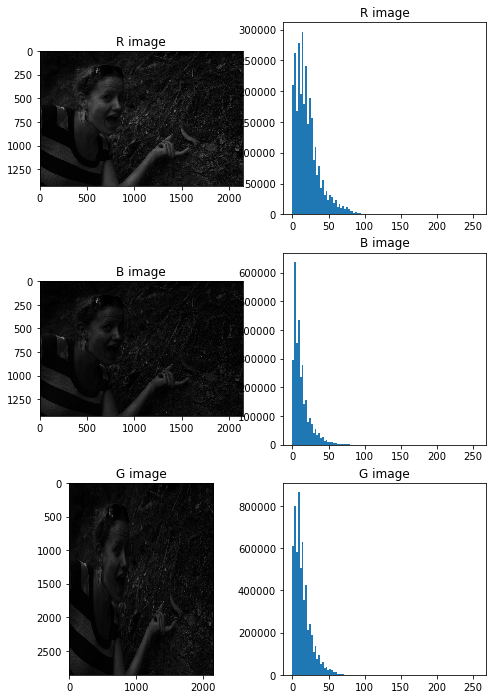

In [28]:
## for identify bayer pattern
for i in range(0, 2):
    rowV=''
    for j in range(0, 2):
        rowV += '(%d, %d)=%f  '%(i, j, rawImgNorm[i,j])
    print(rowV)


## get R G B image
imgG = np.zeros((height, width>>1), dtype=rawImgNorm.dtype)
imgR = rawImgNorm[::2,::2] # red pixels
imgG[0::2,:] = rawImgNorm[::2,1::2] # green pixels
imgG[1::2,:] = rawImgNorm[1::2,::2] # green pixels
imgB = rawImgNorm[1::2,1::2] # blue pixels


##check result
bayer_g = np.zeros(imgG.shape)
ret = cv2.normalize(imgG, bayer_g, 255, 0, cv2.NORM_MINMAX)
bayer_g = np.uint8(bayer_g)

bayer_r = np.zeros(imgR.shape)
ret = cv2.normalize(imgR, bayer_r, 255, 0, cv2.NORM_MINMAX)
bayer_r = np.uint8(bayer_r)

bayer_b = np.zeros(imgB.shape)
ret = cv2.normalize(imgB, bayer_b, 255, 0, cv2.NORM_MINMAX)
bayer_b = np.uint8(bayer_b)

plt.figure(figsize=(8,12))
plt.subplot(321), plt.title("R image"), plt.imshow(bayer_r, cmap=plt.cm.gray)
plt.subplot(322), plt.title("R image"), plt.hist(bayer_r.flatten(), bins=100)
plt.subplot(323), plt.title("B image"), plt.imshow(bayer_b, cmap=plt.cm.gray)
plt.subplot(324), plt.title("B image"), plt.hist(bayer_b.flatten(), bins=100)
plt.subplot(325), plt.title("G image"), plt.imshow(bayer_g, cmap=plt.cm.gray)
plt.subplot(326), plt.title("G image"), plt.hist(bayer_g.flatten(), bins=100)
plt.show()


### White balancing
Implement both white world and gray world automatic white balancing algorithms

In [4]:
##################################################
## gray  world
##################################################
mean_r = np.mean(imgR)
mean_g = np.mean(imgG)
mean_b = np.mean(imgB)
mean_gray = (mean_r + mean_g + mean_b)/3
# white_r = mean_gray/mean_r * imgR
# white_g = mean_gray/mean_g * imgG
# white_b = mean_gray/mean_b * imgB

white_r = mean_g/mean_r * imgR
white_g = imgG
white_b = mean_g/mean_b * imgB



##################################################
## white  world
##################################################
max_r = np.max(imgR)
max_g = np.max(imgG)
max_b = np.max(imgB)
# mean_white = (max_r + max_g + max_b)/3
# white_r = mean_white/max_r * imgR
# white_g = mean_white/max_g * imgG
# white_b = mean_white/max_b * imgB

white_r2 = max_g/max_r * imgR
white_g2 = imgG
white_b2 = max_g/max_b * imgB

print("gray r: mean:" + str(mean_r[0]) + " max:"+ str(max_r) + " min:" + str(np.min(imgR)))
print("gray g: mean:" + str(mean_g[0]) + " max:"+ str(max_g) + " min:" + str(np.min(imgG)))
print("gray b: mean:" + str(mean_b[0]) + " max:"+ str(max_b) + " min:" + str(np.min(imgB)))

print("white r max:"+ str(np.max(white_r)) + " min:" + str(np.min(white_r)))
print("white g max:"+ str(np.max(white_g)) + " min:" + str(np.min(white_g)))
print("white b max:"+ str(np.max(white_b)) + " min:" + str(np.min(white_b)))


gray r: mean:8.09546736878 max:96.70037829074344 min:0.0
gray g: mean:14.817276296 max:255.0 min:0.0
gray b: mean:8.48813459759 max:167.11920018528525 min:0.0
white r max:176.99240300624732 min:0.0
white g max:255.0 min:0.0
white b max:291.7309256867513 min:0.0


### Demosaicing
Use bilinear interpolation for demosaicking

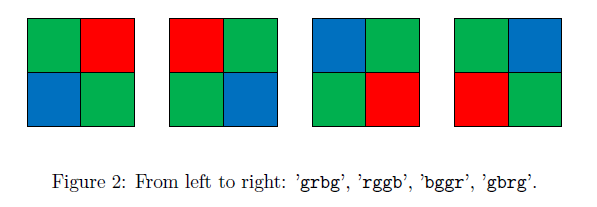

In [5]:
## gray world
large_imgR = cv2.resize(white_r, (width, height), cv2.INTER_LINEAR)
large_imgG = cv2.resize(white_g, (width, height), cv2.INTER_LINEAR)
large_imgB = cv2.resize(white_b, (width, height), cv2.INTER_LINEAR)

gcolor_image = np.zeros(rawImgNorm.shape + (3,))
gcolor_image[:,:,0] = large_imgB
gcolor_image[:,:,1] = large_imgG
gcolor_image[:,:,2] = large_imgR


## white world
large_imgR2 = cv2.resize(white_r2, (width, height), cv2.INTER_LINEAR)
large_imgG2 = cv2.resize(white_g2, (width, height), cv2.INTER_LINEAR)
large_imgB2 = cv2.resize(white_b2, (width, height), cv2.INTER_LINEAR)

wcolor_image = np.zeros(rawImgNorm.shape + (3,))
wcolor_image[:,:,0] = large_imgB2
wcolor_image[:,:,1] = large_imgG2
wcolor_image[:,:,2] = large_imgR2

### Brightness adjustment and gamma correction

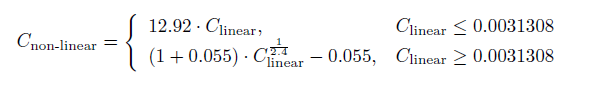


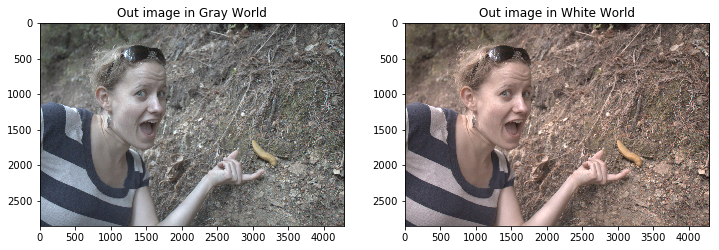

In [27]:
##################################################
## correction RGB--gray world
##################################################
color_image = gcolor_image * 3
color_image = np.minimum(color_image, 255)
ret,large_bgr_t1 = cv2.threshold(color_image, 0.0031308, 0, cv2.THRESH_TOZERO_INV )
ret,large_bgr_t2 = cv2.threshold(color_image, 0.0031308, 0, cv2.THRESH_TOZERO)
ggamma_bgr = large_bgr_t1 * 12.92 + (1+0.055)* np.power(large_bgr_t2,1/2.4)-0.055

cv2.normalize(ggamma_bgr, ggamma_bgr, 255, 0, cv2.NORM_MINMAX)
ggamma_bgr = np.uint8(ggamma_bgr)
ggamma_rgb = ggamma_bgr[...,::-1]

##################################################
## correction RGB--white world
##################################################
color_image = wcolor_image * 3
color_image = np.minimum(color_image, 255)
ret,large_bgr_t1 = cv2.threshold(color_image, 0.0031308, 0, cv2.THRESH_TOZERO_INV )
ret,large_bgr_t2 = cv2.threshold(color_image, 0.0031308, 0, cv2.THRESH_TOZERO)
wgamma_bgr = large_bgr_t1 * 12.92 + (1+0.055)* np.power(large_bgr_t2,1/2.4)-0.055

cv2.normalize(wgamma_bgr, wgamma_bgr, 255, 0, cv2.NORM_MINMAX)
wgamma_bgr = np.uint8(wgamma_bgr)
wgamma_rgb = wgamma_bgr[...,::-1]


##################################################
## show the out image
##################################################
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Out image in Gray World')
plt.imshow(ggamma_rgb)
plt.subplot(1,2,2)
plt.title('Out image in White World')
plt.imshow(wgamma_rgb)
plt.show()



### Compression

Use the imwrite command to store the image in .PNG format (no compression), and also in .JPEG format with
quality setting 95. This setting determines the amount of compression. Can you tell the difference between
the two files? 

The compression ratio is the ratio between the size of the uncompressed file (in bytes) and the
size of the compressed file (in bytes). 

What is the compression ratio?
By changing the JPEG quality settings, determine the lowest setting

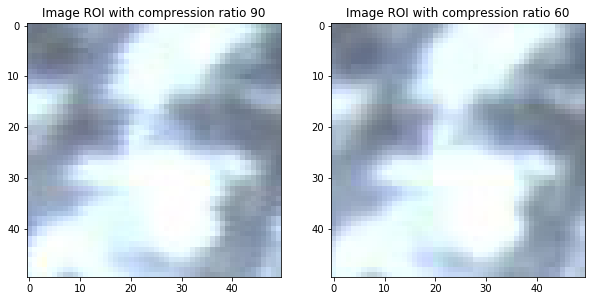

In [74]:
# cv2.imwrite('../data/out_gamma_gray_0.png', ggamma_bgr, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])
# cv2.imwrite('../data/out_gamma_gray_5.png', ggamma_bgr, [int(cv2.IMWRITE_PNG_COMPRESSION), 5])
# cv2.imwrite('../data/out_gamma_gray_100.jpg', ggamma_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
# cv2.imwrite('../data/out_gamma_gray_90.jpg', ggamma_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
# cv2.imwrite('../data/out_gamma_gray_60.jpg', ggamma_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 60])

import skimage.io as skio

out_90 = skio.imread('../data/out_gamma_gray_90.jpg')
out_60 = skio.imread('../data/out_gamma_gray_60.jpg')

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
imgROI = out_90[400:450, 1180:1230]
plt.title('Image ROI with compression ratio 90')
plt.imshow(imgROI)
plt.subplot(1,2,2)
imgROI = out_60[400:450, 1180:1230]
plt.title('Image ROI with compression ratio 60')
plt.imshow(imgROI)
plt.show()


The png file with quality setting 0 can get the lossless compression image, but jpeg cannot.

As the JPEG compression ratio decreases, the quality and size of the image exponentially decline

With my experience, the lowest jpeg setting is 90

## Bonus: Perform manual white balancing

As we discussed in class, one way to do manual white balancing is by: 1) selecting some patch in the scene
that you expect to be white; and 2) normalizing all three channels using weights that make the red, green,
and blue channel values of this patch be equal.
Implement this manual white balancing algorithm, and experiment with different patches in the scene.
Show results for using different patches, and discuss which patches work best. 

r max:185.3316 g:200.9368 b:215.4132


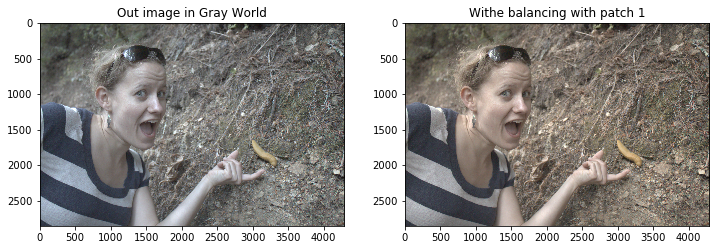

In [126]:
## patch 1
rgb_patch1 = ggamma_rgb[400:450, 1180:1230]
r_patch1 = rgb_patch1[:,:,0]
g_patch1 = rgb_patch1[:,:,1]
b_patch1 = rgb_patch1[:,:,2]


rp_mean = np.mean(r_patch1)
gp_mean = np.mean(g_patch1)
bp_mean = np.mean(b_patch1)
print("r max:"+ str(rp_mean) + " g:" + str(gp_mean) + ' b:' + str(bp_mean))

auto_white_image = np.zeros(ggamma_rgb.shape, dtype='uint8')
auto_r = gp_mean/rp_mean * ggamma_rgb[:,:,0]
auto_b = gp_mean/bp_mean * ggamma_rgb[:,:,2]
auto_white_image[:,:,0] = np.uint8(np.minimum(auto_r, 255))
auto_white_image[:,:,1] = ggamma_rgb[:,:,1]
auto_white_image[:,:,2] = np.uint8(np.minimum(auto_b, 255))

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title('Out image in Gray World')
plt.imshow(ggamma_rgb)
plt.subplot(1,2,2)
plt.title('Withe balancing with patch 1')
plt.imshow(auto_white_image)
plt.show()
